In [ ]:
# ============================================================
# run_universal_constraints.py — FULL WORKING SCRIPT
# ============================================================
import os
import sys
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from gridworld_env_layout import GridWorldMDPFromLayoutEnv
from gridworld_env import NoisyLinearRewardFeaturizedGridWorldEnv
import numpy as np
from agent.q_learning_agent import ValueIteration, PolicyEvaluation
from scipy.optimize import linprog
from utils import generate_random_gridworld_envs

from utils import simulate_all_feedback
from utils import (
    compute_successor_features_family,
    derive_constraints_from_q_family,
    derive_constraints_from_atoms,
    generate_candidate_atoms_for_scot,
    sample_random_atoms_like_scot,
    compute_Q_from_weights_with_VI,
    regrets_from_Q,
    atom_to_constraints
)

from teaching import scot_greedy_family_atoms_tracked

from reward_learning.multi_env_atomic_birl import MultiEnvAtomicBIRL




# 1) Generate envs + solve with Value Iteration
W_TRUE = np.array([-10, -2]) / np.linalg.norm([-10, -2])

envs, meta = generate_random_gridworld_envs(
    n_envs=50,
    rows=3, cols=3,
    color_to_feature_map={"red":[1.0,0.0], "blue":[0.0,1.0]},
    palette=("red","blue"),
    p_color_range={"red":(0.2,0.6), "blue":(0.4,0.8)},
    terminal_policy=dict(kind="random_k", k_min=0, k_max=1, p_no_terminal=0.1),
    gamma_range=(0.98, 0.995),
    noise_prob_range=(0.0, 0.0),
    w_mode="fixed",
    W_fixed=W_TRUE,
    seed=45,
    GridEnvClass=GridWorldMDPFromLayoutEnv,
)

vis = [ValueIteration(e) for e in envs]
for v in vis:
    v.run_value_iteration(epsilon=1e-10)
Q_list = [v.get_q_values() for v in vis]


# 2) Successor features
SFs = compute_successor_features_family(
    envs,
    Q_list,
    convention="entering",
    zero_terminal_features=True,
    tol=1e-10,
    max_iters=10000,
)


# 3) Q-only constraints
## I probably need to make this parallel
U_q_per_env, U_q_global = derive_constraints_from_q_family(
    SFs,
    Q_list,
    envs,
    tie_eps=1e-10,
    skip_terminals=True,
    normalize=True,
    tol=1e-12,
    precision=1e-3,
    lp_epsilon=1e-4,
)

## I probably need to make this parallel
# 4) Simulate feedback atoms (pairwise, estop, improvement, demo)
atoms_per_env = simulate_all_feedback(envs, Q_list, n_base_trajs=200, n_improvements=200, n_pairwise=200, n_estops=200)


## I probably need to make this parallel
# 5) Atom-based constraints
U_atoms_per_env, U_atoms_global = derive_constraints_from_atoms(
    atoms_per_env,
    SFs,
    envs,
    precision=1e-3,
    lp_epsilon=1e-4,
)

# 6) Final Universal Set = union of Q-only + atom constraints
import numpy as np
from utils import remove_redundant_constraints

all_global = []
if len(U_q_global) > 0:
    all_global.append(U_q_global)
if len(U_atoms_global) > 0:
    all_global.append(U_atoms_global)

if all_global:
    stacked = np.vstack(all_global)
    U_universal = remove_redundant_constraints(stacked, epsilon=1e-4)
else:
    d = SFs[0][0].shape[-1]
    U_universal = np.zeros((0, d))

print("Universal constraint set size:", len(U_universal))

candidates_per_env = generate_candidate_atoms_for_scot(
    envs,
    Q_list,
    use_q_demos=True,
    use_pairwise=True,
    use_estop=True,
    use_improvement=True,
    n_pairwise=200,
    n_estops=200,
    n_improvements=200
)

chosen_atoms, stats = scot_greedy_family_atoms_tracked(
    U_universal,
    candidates_per_env,
    SFs,
    envs
)
# Make random selection instead of SCOT
random_chosen_atoms = sample_random_atoms_like_scot(candidates_per_env, chosen_atoms)



def birl_atomic_to_Q_lists(envs, atoms_flat, *, 
                           beta=10, epsilon=1e-4, samples=2000, stepsize=0.1,
                           normalize=True, adaptive=True,
                           burn_frac=0.2, skip_rate=10, vi_epsilon=1e-6):
    """
    Runs MultiEnvAtomicBIRL and returns:
        w_map, w_mean, Q_map_list, Q_mean_list, birl
    """

    birl = MultiEnvAtomicBIRL(
        envs,
        atoms_flat,
        beta_demo=beta,
        beta_pairwise=beta,
        beta_estop=beta,
        beta_improvement=beta,
        epsilon=epsilon
    )

    birl.run_mcmc(samples=samples, stepsize=stepsize, 
                  normalize=normalize, adaptive=adaptive)

    w_map  = birl.get_map_solution()
    w_mean = birl.get_mean_solution(burn_frac=burn_frac, skip_rate=skip_rate)

    Q_map_list  = [compute_Q_from_weights_with_VI(env, w_map,  vi_epsilon=vi_epsilon)
                   for env in envs]
    Q_mean_list = [compute_Q_from_weights_with_VI(env, w_mean, vi_epsilon=vi_epsilon)
                   for env in envs]

    return w_map, w_mean, Q_map_list, Q_mean_list, birl

def run_scot_vs_random_Q_regret_atomic(
    envs,
    chosen_scot,       # [(env_idx, Atom)]
    make_random_chosen,  # callable(seed) -> [(env_idx, Atom)]
    *,
    n_random_trials=10,
    seeds=None,
    birl_kwargs=None,
    vi_epsilon=1e-6,
    tie_eps=1e-10,
    regret_epsilon=1e-4,
    normalize_regret=False,
):
    """
    Compare regret(SCOT) vs regret(Random baseline) using atomic-format feedback.
    """

    m = len(envs)
    birl_kwargs = birl_kwargs or {}

    # ----------------------------------------------------
    # 1. Run Atomic BIRL on SCOT
    # ----------------------------------------------------
    w_scot_map, w_scot_mean, Q_scot_map, Q_scot_mean, birl_scot = \
        birl_atomic_to_Q_lists(envs, chosen_scot,
                               vi_epsilon=vi_epsilon,
                               **birl_kwargs)

    reg_scot_map = regrets_from_Q(envs, Q_scot_map,
                                  tie_eps=tie_eps, epsilon=regret_epsilon,
                                  normalize_with_random_policy=normalize_regret)

    reg_scot_mean = regrets_from_Q(envs, Q_scot_mean,
                                   tie_eps=tie_eps, epsilon=regret_epsilon,
                                   normalize_with_random_policy=normalize_regret)

    # ----------------------------------------------------
    # 2. Random baseline over multiple seeds
    # ----------------------------------------------------
    if seeds is None:
        seeds = list(range(n_random_trials))

    rand_map_regs_by_seed  = []
    rand_mean_regs_by_seed = []

    for sd in seeds:
        chosen_rand = make_random_chosen(sd)  # returns [(env_idx, Atom)]

        _, _, Q_rand_map, Q_rand_mean, _ = birl_atomic_to_Q_lists(
            envs,
            chosen_rand,
            vi_epsilon=vi_epsilon,
            **birl_kwargs
        )

        reg_rand_map = regrets_from_Q(envs, Q_rand_map,
                                      tie_eps=tie_eps, epsilon=regret_epsilon,
                                      normalize_with_random_policy=normalize_regret)

        reg_rand_mean = regrets_from_Q(envs, Q_rand_mean,
                                       tie_eps=tie_eps, epsilon=regret_epsilon,
                                       normalize_with_random_policy=normalize_regret)

        rand_map_regs_by_seed.append(reg_rand_map)
        rand_mean_regs_by_seed.append(reg_rand_mean)

    rand_map_regs_by_seed  = np.stack(rand_map_regs_by_seed,  axis=0)  # (T, M)
    rand_mean_regs_by_seed = np.stack(rand_mean_regs_by_seed, axis=0)  # (T, M)

    # averages per environment over seeds
    rand_map_per_env_mean  = rand_map_regs_by_seed.mean(axis=0)
    rand_mean_per_env_mean = rand_mean_regs_by_seed.mean(axis=0)

    # ----------------------------------------------------
    # Stats helper
    # ----------------------------------------------------
    def _stats(x):
        return dict(
            mean=float(np.mean(x)),
            std=float(np.std(x)),
            median=float(np.median(x)),
            min=float(np.min(x)),
            max=float(np.max(x)),
        )

    # ----------------------------------------------------
    # Final output dict
    # ----------------------------------------------------
    return {
        "SCOT": {
            "w_map": w_scot_map,
            "w_mean": w_scot_mean,
            "regret_map_per_env":  reg_scot_map,
            "regret_mean_per_env": reg_scot_mean,
            "summary_map":  _stats(reg_scot_map),
            "summary_mean": _stats(reg_scot_mean),
        },
        "RANDOM_over_seeds": {
            "regret_map_by_seed":  rand_map_regs_by_seed,
            "regret_mean_by_seed": rand_mean_regs_by_seed,
            "per_env_seed_mean_map":  rand_map_per_env_mean,
            "per_env_seed_mean_mean": rand_mean_per_env_mean,
            "summary_seed_mean_map":  _stats(rand_map_per_env_mean),
            "summary_seed_mean_mean": _stats(rand_mean_per_env_mean),
            "seeds": seeds,
        },
        "Q_lists": {
            "SCOT_MAP":  Q_scot_map,
            "SCOT_MEAN": Q_scot_mean,
        },
        "birl": {
            "SCOT": birl_scot
        },
        "config": {
            "vi_epsilon": vi_epsilon,
            "regret_epsilon": regret_epsilon,
            "tie_eps": tie_eps,
            "normalize_regret": normalize_regret,
        },
    }


SCOT regret shape: (20,)
Random regret shape (seeds x envs): (10, 20)

=== Summary ===
SCOT overall mean regret:   124.460683
Random mean regret (per seed): mean=9.059574, std=27.130406


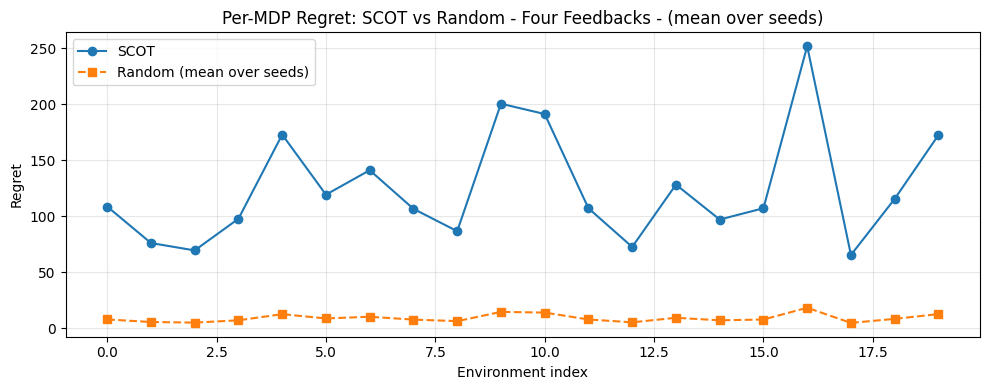

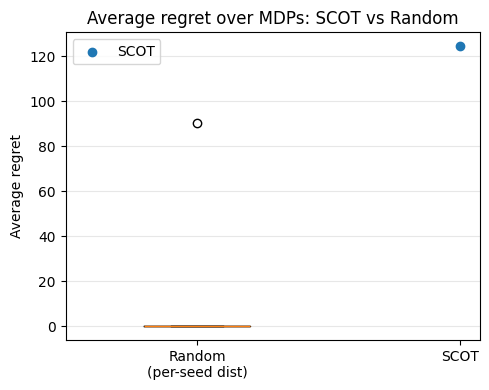

In [9]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------------------------
# 1. Load JSON results
# ---------------------------------------------------------
# Change this to your result file path:
RESULTS_PATH = Path("results_universal/exp_env20_size5_fd3_fb5000_20251203-063756/results.json")

with open(RESULTS_PATH, "r") as f:
    results = json.load(f)

scot_reg_env = np.array(results["SCOT"]["regret_map"])          # shape: (M,)
rand_reg_env_seeds = np.array(results["RANDOM"]["regret_map"])  # shape: (T, M)

# Sanity check
print("SCOT regret shape:", scot_reg_env.shape)
print("Random regret shape (seeds x envs):", rand_reg_env_seeds.shape)

# ---------------------------------------------------------
# 2. Aggregate statistics
# ---------------------------------------------------------
env_ids = np.arange(len(scot_reg_env))
rand_reg_env_mean = rand_reg_env_seeds.mean(axis=0)       # per-env mean over seeds
rand_reg_env_std  = rand_reg_env_seeds.std(axis=0)

scot_overall_mean = scot_reg_env.mean()
rand_overall_by_seed = rand_reg_env_seeds.mean(axis=1)    # one value per seed

print("\n=== Summary ===")
print(f"SCOT overall mean regret:   {scot_overall_mean:.6f}")
print(f"Random mean regret (per seed): mean={rand_overall_by_seed.mean():.6f}, "
      f"std={rand_overall_by_seed.std():.6f}")

# ---------------------------------------------------------
# 3. Plot: Per-env regret (SCOT vs Random mean)
# ---------------------------------------------------------
plt.figure(figsize=(10, 4))
plt.title("Per-MDP Regret: SCOT vs Random - Four Feedbacks - (mean over seeds)")
plt.plot(env_ids, scot_reg_env, marker="o", linestyle="-", label="SCOT")
plt.plot(env_ids, rand_reg_env_mean, marker="s", linestyle="--", label="Random (mean over seeds)")

plt.xlabel("Environment index")
plt.ylabel("Regret")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

# ---------------------------------------------------------
# 4. Plot: Distribution of avg regret over seeds
# ---------------------------------------------------------
plt.figure(figsize=(5, 4))
plt.title("Average regret over MDPs: SCOT vs Random")

# Boxplot for random (per-seed mean)
plt.boxplot(rand_overall_by_seed, positions=[0], widths=0.4)
plt.scatter([1], [scot_overall_mean], marker="o", label="SCOT")

plt.xticks([0, 1], ["Random\n(per-seed dist)", "SCOT"])
plt.ylabel("Average regret")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## make bar 
## make better visualization

[Four feedbacks] SCOT mean regret = 0.000000, Random mean = 9.241768 ± 27.074800
[Pairwise preference] SCOT mean regret = 124.460683, Random mean = 9.059574 ± 27.130406
[Coorrection] SCOT mean regret = 0.000000, Random mean = 0.347778 ± 0.953727
[Estop] SCOT mean regret = 28.364596, Random mean = 51.671895 ± 43.238631
[Demo] SCOT mean regret = 0.000000, Random mean = 0.041345 ± 0.020705


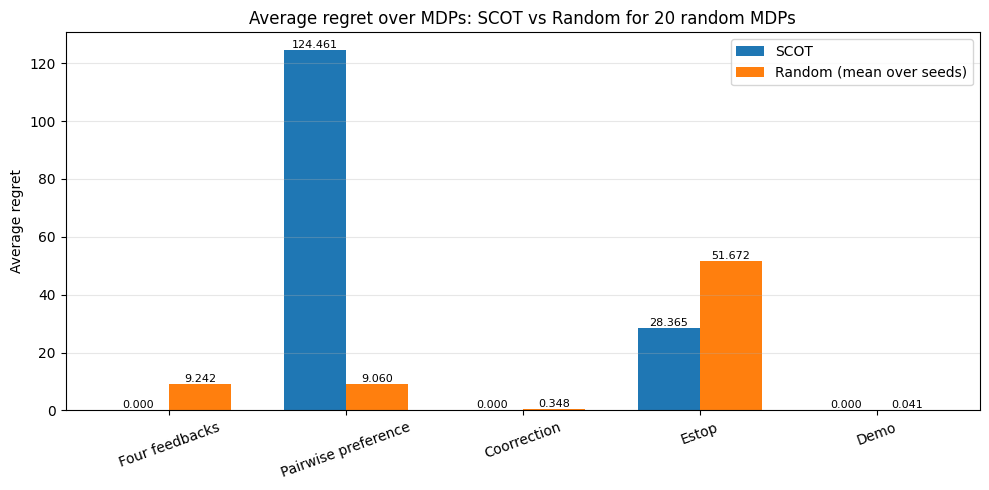

In [10]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------------------------
# 1. List your result files here
#    key = label for that experiment (used on x-axis)
#    value = path to its results.json
# ---------------------------------------------------------
RESULT_FILES = {
    "Four feedbacks": "results_universal/exp_env20_size5_fd3_fb5000_20251203-063658/results.json",
    "Pairwise preference": "results_universal/exp_env20_size5_fd3_fb5000_20251203-063756/results.json",
    "Coorrection": "results_universal/exp_env20_size5_fd3_fb5000_20251203-063825/results.json",
    "Estop": "results_universal/exp_env20_size5_fd3_fb5000_20251203-063854/results.json",
    "Demo": "results_universal/exp_env20_size5_fd3_fb5000_20251203-063724/results.json"

    # Add more like:
    # "demos_only": "results_universal/exp_env20_size5_fd3_fb5000_20251203-070000/results.json",
    # "pairwise_only": "results_universal/exp_env20_size5_fd3_fb5000_20251203-071500/results.json",
}

# ---------------------------------------------------------
# 2. Parse all files & collect stats
# ---------------------------------------------------------
labels = []
scot_means = []
rand_means = []
rand_stds = []

for exp_label, path_str in RESULT_FILES.items():
    path = Path(path_str)
    if not path.exists():
        print(f"[WARN] File not found: {path}")
        continue

    with open(path, "r") as f:
        results = json.load(f)

    # SCOT regret per env
    scot_reg_env = np.array(results["SCOT"]["regret_map"])  # shape (M,)

    # RANDOM: regret_map is (T, M): T seeds, M envs
    rand_reg_env_seeds = np.array(results["RANDOM"]["regret_map"])  # shape (T, M)

    # Overall averages
    scot_overall_mean = scot_reg_env.mean()

    # mean regret per seed (averaging over envs), then average over seeds
    rand_overall_by_seed = rand_reg_env_seeds.mean(axis=1)  # shape (T,)
    rand_overall_mean = rand_overall_by_seed.mean()
    rand_overall_std = rand_overall_by_seed.std()

    print(f"[{exp_label}] SCOT mean regret = {scot_overall_mean:.6f}, "
          f"Random mean = {rand_overall_mean:.6f} ± {rand_overall_std:.6f}")

    labels.append(exp_label)
    scot_means.append(scot_overall_mean)
    rand_means.append(rand_overall_mean)
    rand_stds.append(rand_overall_std)

scot_means = np.array(scot_means)
rand_means = np.array(rand_means)
rand_stds = np.array(rand_stds)

# ---------------------------------------------------------
# 3. Grouped bar plot: each experiment → (SCOT, Random)
# ---------------------------------------------------------
x = np.arange(len(labels))  # positions for groups
width = 0.35                # bar width

plt.figure(figsize=(10, 5))
plt.title("Average regret over MDPs: SCOT vs Random for 20 random MDPs")

# SCOT bars
plt.bar(x - width/2, scot_means, width, label="SCOT")

# Random bars with error bars (std over seeds)
plt.bar(x + width/2, rand_means, width,
        capsize=4, label="Random (mean over seeds)")

plt.xticks(x, labels, rotation=20)
plt.ylabel("Average regret")
plt.grid(axis="y", alpha=0.3)
plt.legend()

# Optional: annotate values on top of bars
for i in range(len(labels)):
    plt.text(x[i] - width/2, scot_means[i],
             f"{scot_means[i]:.3f}",
             ha="center", va="bottom", fontsize=8)
    plt.text(x[i] + width/2, rand_means[i],
             f"{rand_means[i]:.3f}",
             ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()
